# Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
# set seeds for reproducable results
random.seed(1234)
tf.random.set_seed(1234)

# Data

In [3]:
X = np.load('data/X.npy')
y = np.load('data/y.npy')

In [4]:
print(f'X has a shape of {X.shape}')
print(f'y has a shape of {y.shape}')

X has a shape of (5000, 400)
y has a shape of (5000, 1)


In [5]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

We have split our data into two subsets: training and test data. This way we can identify if our model is overfitting the data.

# Train Model

In [18]:
model = Sequential(
    [
        Input(shape=(400,)),
        Dense(25, activation ='relu'),
        Dense(15, activation = 'relu'),
        Dense(10, activation = 'linear')
    ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 25)                  │          10,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,575 (41.31 KB)

 Trainable params: 10,575 (41.31 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# define loss function
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = Adam(0.001)
)

# train model
num_epochs = 20
history = model.fit(X_train,y_train,epochs = num_epochs)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.0432
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9114  
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5489
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4268
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3627
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3216
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2899
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2654
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2453
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.2288
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.2144
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 0.2019
Epoch 13/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.1905
Epoch 14/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.1802
Epoch 15/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9

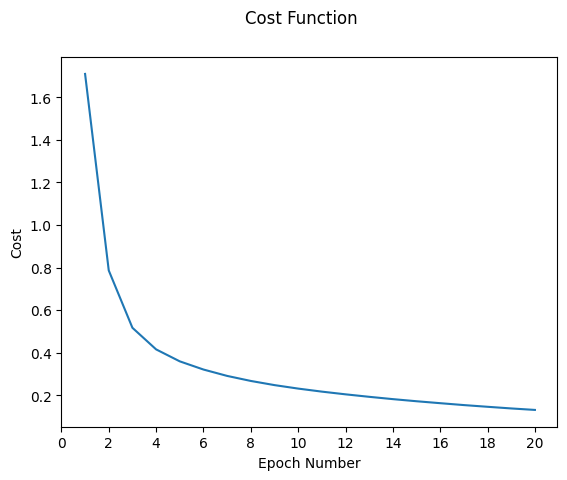

In [22]:
# plot cost function
plt.plot(history.epoch+np.ones(num_epochs),history.history['loss'])
plt.suptitle('Cost Function')
plt.ylabel('Cost')
plt.xlabel('Epoch Number')
tick_positions = range(0,num_epochs+1,2)
plt.xticks(tick_positions)
plt.show()

Cost is a metric for how poorly our model fits our training data. It is good to see it come down. Let's see how accurate its predictions are.

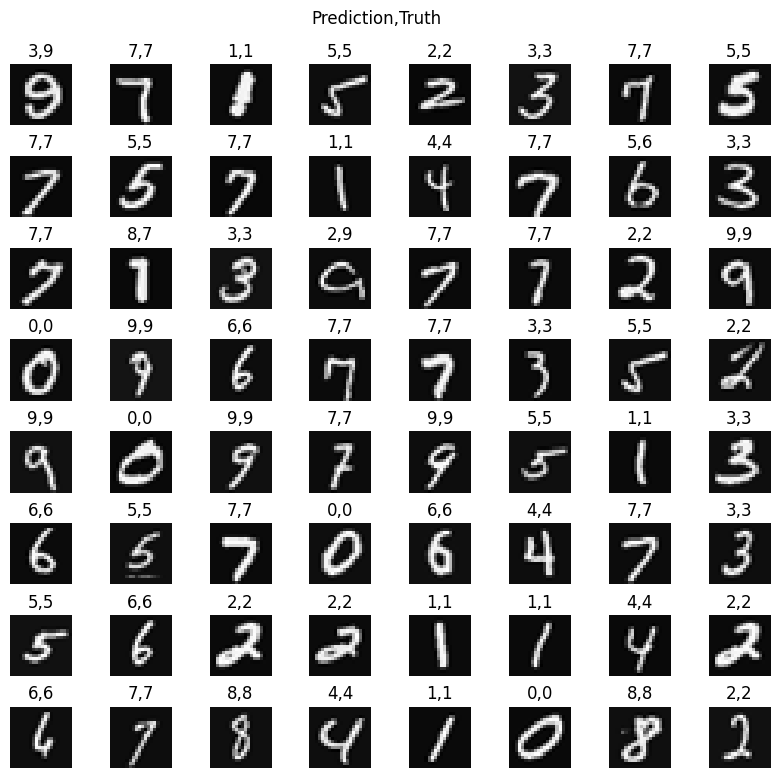

In [23]:
m,n = X_test.shape
fig, axes = plt.subplots(8,8,figsize=(8,8))
fig.tight_layout(pad = 0.1, rect = (0,0,1,0.92))
fig.suptitle('Prediction,Truth')
truth_list = []

for ax in axes.flat:
    index = random.randint(0,m-1)
    prediction = np.argmax(model.predict(X_test[index].reshape(1,n), verbose=0))
    truth_list.append(prediction == y_test[index][0])
    ax.imshow(X_test[index].reshape(20,20).T, cmap = 'gray')
    ax.set_title(f'{prediction},{y_test[index][0]}')
    ax.set_axis_off()

plt.show()

In [24]:
print(f'{sum(truth_list)} out of {len(axes.flat)} digits correctly predicted')

60 out of 64 digits correctly predicted
